In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

matrix= scipy.io.loadmat("/home/ponnana/PhD/Yinling_copy/data_new.mat")

m = matrix["data_new"][:,0]
v =  matrix["data_new"][:,1]
s = matrix["data_new"][:,2]
k = matrix["data_new"][:,3]

tExp = [0.01058, 0.03158, 0.05258, 0.07358, 0.09458, 0.1156, 0.1366, 0.1576, 0.1786, 0.1996, 0.2206,
          0.2300, 0.2756, 0.3316, 0.3876, 0.4436, 0.4496, 0.5556, 0.6116, 0.6676, 0.7206, 0.7796, 0.8356,
          0.8916, 0.9476, 1.004, 1.060, 1.105, 1.124, 1.153, 1.182, 1.211, 1.240, 1.269, 1.298, 1.327,
          1.356, 1.385, 1.414, 1.443, 1.472, 1.501, 1.530, 1.559, 1.588, 1.617, 1.646, 1.670]

tExp = np.array(tExp)


t1,t2 = 0.24,1.1
xExp = np.concatenate((matrix["data_new"], tExp.reshape(-1,1)), axis=1)
xExp = xExp.astype(float)


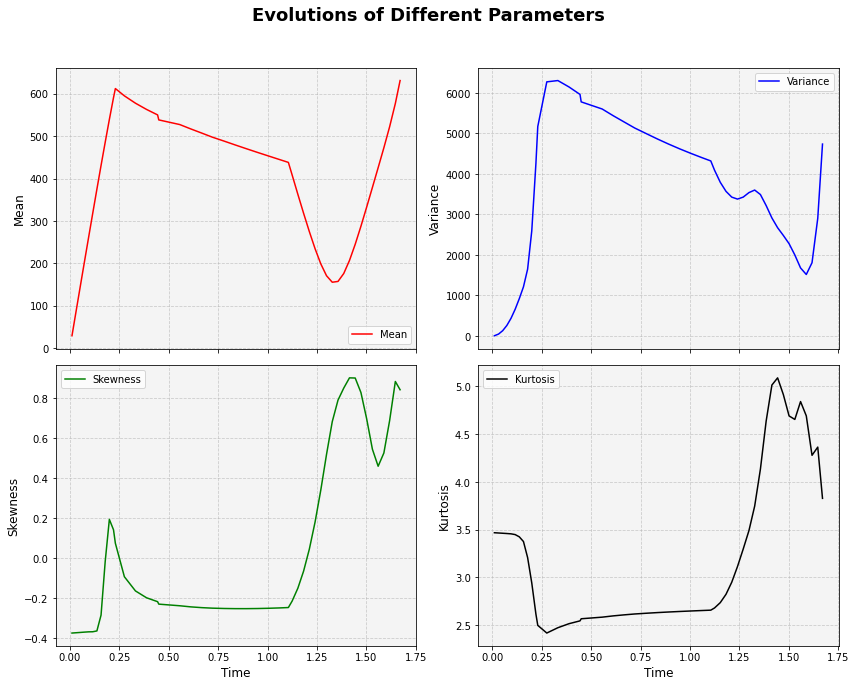

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

# Plot Mean
axs[0, 0].plot(tExp, xExp[:, 0], 'r', label='Mean')
axs[0, 0].set_ylabel("Mean", fontsize=12)
axs[0, 0].legend()
axs[0, 0].set_facecolor('#F4F4F4')
axs[0, 0].grid(True, linestyle='--', alpha=0.6)

# Plot Variance
axs[0, 1].plot(tExp, xExp[:, 1], 'b', label='Variance')
axs[0, 1].set_ylabel("Variance", fontsize=12)
axs[0, 1].legend()
axs[0, 1].set_facecolor('#F4F4F4')
axs[0, 1].grid(True, linestyle='--', alpha=0.6)

# Plot Skewness
axs[1, 0].plot(tExp, xExp[:, 2], 'g', label='Skewness')
axs[1, 0].set_xlabel("Time", fontsize=12)
axs[1, 0].set_ylabel("Skewness", fontsize=12)
axs[1, 0].legend()
axs[1, 0].set_facecolor('#F4F4F4')
axs[1, 0].grid(True, linestyle='--', alpha=0.6)

# Plot Kurtosis
axs[1, 1].plot(tExp, xExp[:, 3], 'k', label='Kurtosis')
axs[1, 1].set_xlabel("Time", fontsize=12)
axs[1, 1].set_ylabel("Kurtosis", fontsize=12)
axs[1, 1].legend()
axs[1, 1].set_facecolor('#F4F4F4')
axs[1, 1].grid(True, linestyle='--', alpha=0.6)

# Customize the overall appearance
fig.suptitle("Evolutions of Different Parameters", fontsize=18, fontweight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to prevent clipping

# Show the plot
plt.show()


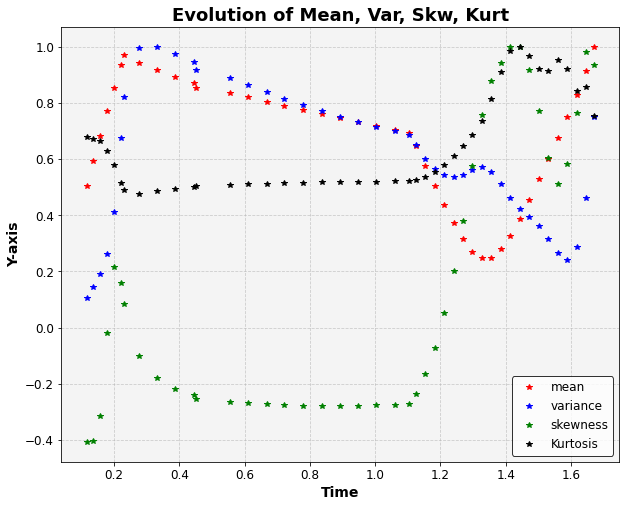

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(tExpTrunc,xExpTruncNormal[:,0], 'r*',label='mean')

plt.plot(tExpTrunc,xExpTruncNormal[:,1], 'b*',label='variance')

plt.plot(tExpTrunc,xExpTruncNormal[:,2], 'g*',label='skewness')

plt.plot(tExpTrunc,xExpTruncNormal[:,3], 'k*',label='Kurtosis')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("Evolution of Mean, Var, Skw, Kurt", fontsize=18, fontweight='bold')
ax.set_xlabel("Time", fontsize=14, fontweight='bold')
ax.set_ylabel("Y-axis", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='lower right', fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')

# Show the plot
plt.show()


In [4]:
maxValues = np.max(xExp,axis=0)
maxValues[-1]=1
xExpNormal = xExp/maxValues
truncIndex = np.where(xExpNormal[:,1]>=0.0999)
xExpTruncNormal = xExpNormal[truncIndex,:]
xExpTruncNormal = np.squeeze(xExpTruncNormal)

tExpTrunc = xExpTruncNormal[:,-1]


In [6]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1000)
np.random.seed(1000)

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=15)
parser.add_argument('--batch_size', type=int, default=100)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')

# Parse arguments when running in Jupyter notebook
args = parser.parse_args(args=[])

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [7]:
from scipy.interpolate import interp1d
tTrain = np.linspace(np.min(tExpTrunc), np.max(tExpTrunc), args.data_size)
quad_interp = interp1d(tExpTrunc, xExpTruncNormal, kind='quadratic', axis=0)
xTrain = quad_interp(tTrain) 

In [8]:
dmeanBydtTemp = xTrain[1:,0]-xTrain[0:-1,0]
dvarBydtTemp = xTrain[1:,1]-xTrain[0:-1,1]
dskwBydtTemp = xTrain[1:,2]-xTrain[0:-1,2]
dkurtBydtTemp = xTrain[1:,3]-xTrain[0:-1,3]
timeStep= tTrain[1]-tTrain[0]

dmeanBydtTemp = dmeanBydtTemp/timeStep
dvarBydtTemp = dvarBydtTemp/timeStep
dskwBydtTemp = dskwBydtTemp/timeStep
dkurtBydtTemp = dkurtBydtTemp/timeStep

dmeanBydt = np.append(dmeanBydtTemp,dmeanBydtTemp[-1])
dvarBydt = np.append(dvarBydtTemp,dvarBydtTemp[-1])
dskwBydt = np.append(dskwBydtTemp,dskwBydtTemp[-1])
dkurtBydt = np.append(dkurtBydtTemp,dkurtBydtTemp[-1])

In [11]:
clear true_y 

In [12]:
## Setting up the true system
true_y0 = torch.from_numpy(xTrain[0,:]).to(device).to(dtype=torch.float)
t = torch.from_numpy(tTrain).to(dtype=torch.float)
true_y = torch.from_numpy(xTrain).unsqueeze(1).to(dtype=torch.float)

In [13]:
s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
batch_y0 = true_y[s]  # (M, D)
batch_t = torch.stack([t[i:i+args.batch_time] for i in s]) # (T)
batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=1)  # (T, M, D)
batch_y=batch_y.permute(2,0,1,3)

In [14]:
## Get mini-batch data from the training dataset 
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = torch.stack([t[i:i+args.batch_time] for i in s]) # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=1)  # (T, M, D)
    batch_y=batch_y.permute(2,0,1,3)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)


In [22]:
t

tensor([0.1156, 0.1172, 0.1187, 0.1203, 0.1218, 0.1234, 0.1249, 0.1265, 0.1280,
        0.1296, 0.1312, 0.1327, 0.1343, 0.1358, 0.1374, 0.1389, 0.1405, 0.1421,
        0.1436, 0.1452, 0.1467, 0.1483, 0.1498, 0.1514, 0.1529, 0.1545, 0.1561,
        0.1576, 0.1592, 0.1607, 0.1623, 0.1638, 0.1654, 0.1669, 0.1685, 0.1701,
        0.1716, 0.1732, 0.1747, 0.1763, 0.1778, 0.1794, 0.1810, 0.1825, 0.1841,
        0.1856, 0.1872, 0.1887, 0.1903, 0.1918, 0.1934, 0.1950, 0.1965, 0.1981,
        0.1996, 0.2012, 0.2027, 0.2043, 0.2058, 0.2074, 0.2090, 0.2105, 0.2121,
        0.2136, 0.2152, 0.2167, 0.2183, 0.2198, 0.2214, 0.2230, 0.2245, 0.2261,
        0.2276, 0.2292, 0.2307, 0.2323, 0.2339, 0.2354, 0.2370, 0.2385, 0.2401,
        0.2416, 0.2432, 0.2447, 0.2463, 0.2479, 0.2494, 0.2510, 0.2525, 0.2541,
        0.2556, 0.2572, 0.2587, 0.2603, 0.2619, 0.2634, 0.2650, 0.2665, 0.2681,
        0.2696, 0.2712, 0.2728, 0.2743, 0.2759, 0.2774, 0.2790, 0.2805, 0.2821,
        0.2836, 0.2852, 0.2868, 0.2883, 

In [34]:
t.dtype

torch.float32

In [32]:
type(temp1)

float

In [27]:
temp1 = batch_t[0,0].item()

In [16]:
## Construct a neural network to approximate the dynamics of an ODE
class ODEFuncMean(nn.Module):

    def __init__(self):
        super(ODEFuncMean, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcMean = ODEFuncMean().to(device)

# ## Construct a neural network to approximate the dynamics of an ODE
# class ODEFuncVariance(nn.Module):

#     def __init__(self):
#         super(ODEFuncVariance, self).__init__()

#         self.net = nn.Sequential(
#             nn.Linear(5, 64),
#             nn.Tanh(),
#             nn.Linear(64, 64),
#             nn.Tanh(),
#             nn.Linear(64, 1)
#         )

#         for m in self.net.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)

#     def forward(self, t, y):
#         return self.net(y)
    
# funcVariance = ODEFuncVariance().to(device)

# ## Construct a neural network to approximate the dynamics of an ODE
# class ODEFuncSkewness(nn.Module):

#     def __init__(self):
#         super(ODEFuncSkewness, self).__init__()

#         self.net = nn.Sequential(
#             nn.Linear(5, 64),
#             nn.Tanh(),
#             nn.Linear(64, 64),
#             nn.Tanh(),
#             nn.Linear(64, 1)
#         )

#         for m in self.net.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)

#     def forward(self, t, y):
#         return self.net(y)
    
# funcSkewness = ODEFuncSkewness().to(device)

# ## Construct a neural network to approximate the dynamics of an ODE
# class ODEFuncKurtosis(nn.Module):

#     def __init__(self):
#         super(ODEFuncKurtosis, self).__init__()

#         self.net = nn.Sequential(
#             nn.Linear(5, 64),
#             nn.Tanh(),
#             nn.Linear(64, 64),
#             nn.Tanh(),
#             nn.Linear(64, 1)
#         )

#         for m in self.net.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)

#     def forward(self, t, y):
#         return self.net(y)
    
# funcKurtosis = ODEFuncKurtosis().to(device)
    
def combined_system(t, y):
    dt_dt = 1;
    dt_dt = torch.tensor([dt_dt])
    dm_dt = funcMean(t, y)  # Using ODEFunc to get dx2/dt, dx3/dt, dx4/dt
    dv_dt = funcVariance(t, y)
    ds_dt = funcSkewness(t, y)
    dk_dt = funcKurtosis(t, y)
    return torch.cat([dm_dt, dv_dt, ds_dt, dk_dt, dt_dt], dim=0)

In [17]:
# Mean
parvalue = 0;

In [19]:
ii = 0
## Setting up the optimizer

# Setting up the optimizer with all parameters
optimizer = optim.RMSprop(funcMean.parameters(), lr=0.0005)

for itr in range(1, args.niters + 1):
#for itr in range(1, 20):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        solutions = []
        temp1 = 0
        for ic in batch_y0:
            sol = odeint(combined_system, ic[0], batch_t[temp1])
            solutions.append(sol)
            temp1 = temp1+1
        pred_y_toCaclLoss= torch.stack(solutions).unsqueeze(0)
        #pred_y = pred_y.permute(2, 1, 0, 3)
        loss = torch.mean(torch.abs(pred_y_toCaclLoss - batch_y))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(combined_system, true_y0, t)
                pred_y = pred_y.unsqueeze(1)  
                loss = torch.mean(torch.abs(pred_y - true_y))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                ii += 1

Iter 0001 | Total Loss 0.423461
Iter 0020 | Total Loss 0.279431
Iter 0040 | Total Loss 0.305646
Iter 0060 | Total Loss 0.290632
Iter 0080 | Total Loss 0.244981
Iter 0100 | Total Loss 0.257544
Iter 0120 | Total Loss 0.258156
Iter 0140 | Total Loss 0.269762
Iter 0160 | Total Loss 0.244972
Iter 0180 | Total Loss 0.267351
Iter 0200 | Total Loss 0.275195
Iter 0220 | Total Loss 0.261228


KeyboardInterrupt: 

In [ ]:
# Setting up the optimizer with all parameters
optimizer = optim.RMSprop(all_parameters, lr=0.000005)

for itr in range(1, 10000):
#for itr in range(1, 20):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        solutions = []
        temp1 = 0
        for ic in batch_y0:
            sol = odeint(combined_system, ic[0], batch_t[temp1])
            solutions.append(sol)
            temp1 = temp1+1
        pred_y_toCaclLoss= torch.stack(solutions).unsqueeze(0)
        #pred_y = pred_y.permute(2, 1, 0, 3)
        loss = torch.mean(torch.abs(pred_y_toCaclLoss - batch_y))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(combined_system, true_y0, t)
                pred_y = pred_y.unsqueeze(1)  
                loss = torch.mean(torch.abs(pred_y - true_y))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                ii += 1

Iter 0001 | Total Loss 0.239540
Iter 0020 | Total Loss 0.240176


NameError: name 'temp_x_t_m_p2' is not defined

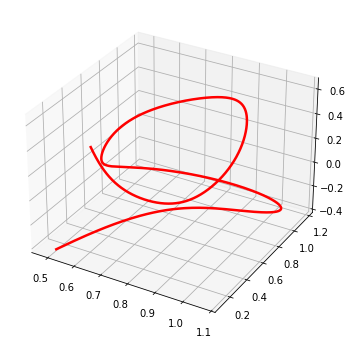

In [24]:
# Assuming ODEFunc is the name of your neural network class
modelMean = funcMean
modelVar = funcVariance
modelSkw = funcSkewness
modelKurt = funcKurtosis


modelMean.eval()
modelVar.eval()
modelSkw.eval()
modelKurt.eval()


# Initial state
y0 = true_y0
#y0= torch.tensor([ 0,  0.5, 0, 0])

# Time point for prediction
t_value = t
with torch.no_grad():
    predicted_states = odeint(combined_system,y0 , t).to(device)
    
predicted_states=predicted_states.numpy()

plot_kws = dict(linewidth=2)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

#ax.plot(x_train[:, 1], x_train[:, 2], x_train[:, 3], "k*", label="$given$")

ax.plot(predicted_states[:, 0], predicted_states[:, 1], predicted_states[:, 2], "r", label="$Neural-ODE-model$", linewidth=2.5,alpha =1)
ax.plot(temp_x_t_m_p2[:, 0], temp_x_t_m_p2[:, 1], temp_x_t_m_p2[:, 2], "b", label="True value", linewidth=2.5,alpha =0.6)
ax.set(xlabel="$Var$", ylabel="$Skw$", zlabel="$Kur$")
ax.legend()
fig.show()

#z_true = true_y[:,0,2].numpy()

In [72]:

# Setting up the optimizer with all parameters
optimizer = optim.RMSprop(all_parameters, lr=0.00001)

for itr in range(2480, 10000):
#for itr in range(1, 20):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        solutions = []
        temp1 = 0
        for ic in batch_y0:
            sol = odeint(combined_system, ic[0], batch_t[temp1])
            solutions.append(sol)
            temp1 = temp1+1
        pred_y_toCaclLoss= torch.stack(solutions).unsqueeze(0)
        #pred_y = pred_y.permute(2, 1, 0, 3)
        loss = torch.mean(torch.abs(pred_y_toCaclLoss - batch_y))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(combined_system, true_y0, t)
                pred_y = pred_y.unsqueeze(1)  
                loss = torch.mean(torch.abs(pred_y - true_y))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                ii += 1

Iter 2480 | Total Loss 0.155466
Iter 2500 | Total Loss 0.152340
Iter 2520 | Total Loss 0.156118
Iter 2540 | Total Loss 0.155207
Iter 2560 | Total Loss 0.156247
Iter 2580 | Total Loss 0.158073
Iter 2600 | Total Loss 0.155651
Iter 2620 | Total Loss 0.155693
Iter 2640 | Total Loss 0.155021
Iter 2660 | Total Loss 0.156813
Iter 2680 | Total Loss 0.159243
Iter 2700 | Total Loss 0.159526
Iter 2720 | Total Loss 0.157380
Iter 2740 | Total Loss 0.157323
Iter 2760 | Total Loss 0.156529
Iter 2780 | Total Loss 0.157434
Iter 2800 | Total Loss 0.158353
Iter 2820 | Total Loss 0.159080
Iter 2840 | Total Loss 0.159608
Iter 2860 | Total Loss 0.159937
Iter 2880 | Total Loss 0.161453
Iter 2900 | Total Loss 0.158084
Iter 2920 | Total Loss 0.158897
Iter 2940 | Total Loss 0.158000
Iter 2960 | Total Loss 0.160115
Iter 2980 | Total Loss 0.159993
Iter 3000 | Total Loss 0.160207
Iter 3020 | Total Loss 0.159961
Iter 3040 | Total Loss 0.158311
Iter 3060 | Total Loss 0.158721
Iter 3080 | Total Loss 0.160123
Iter 310

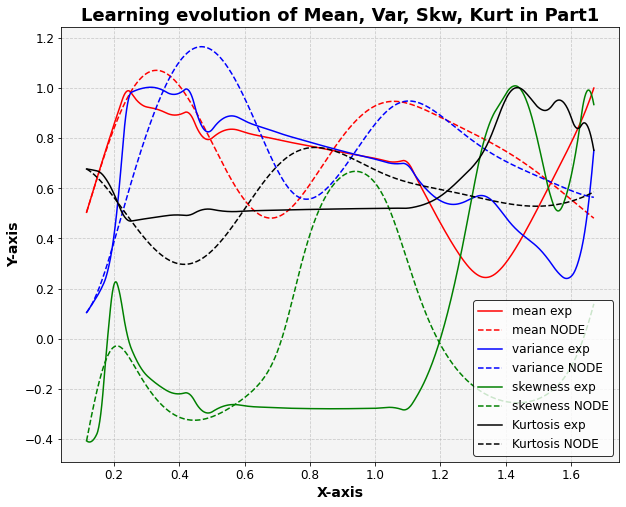

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(tTrain,xTrain[:,0], 'r',label='mean exp')
plt.plot(tTrain,predicted_states[:,0], 'r--',label='mean NODE')

plt.plot(tTrain,xTrain[:,1], 'b',label='variance exp')
plt.plot(tTrain,predicted_states[:,1], 'b--',label='variance NODE')

plt.plot(tTrain,xTrain[:,2], 'g',label='skewness exp')
plt.plot(tTrain,predicted_states[:,2], 'g--',label='skewness NODE')

plt.plot(tTrain,xTrain[:,3], 'k',label='Kurtosis exp')
plt.plot(tTrain,predicted_states[:,3], 'k--',label='Kurtosis NODE')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("Learning evolution of Mean, Var, Skw, Kurt in Part1", fontsize=18, fontweight='bold')
ax.set_xlabel("X-axis", fontsize=14, fontweight='bold')
ax.set_ylabel("Y-axis", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='lower right', fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')

plt.savefig('individualNN_64_64_1.pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [28]:
torch.save(funcMean, 'mean64_64.pth')
torch.save(funcVariance, 'variance64_64.pth')
torch.save(funcSkewness, 'skewness64_64.pth')
torch.save(funcKurtosis, 'kurtosis64_64.pth')

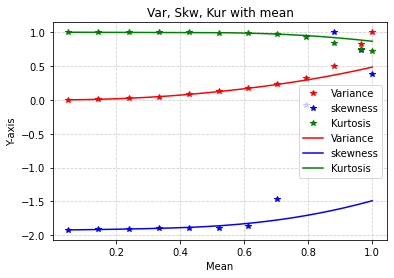

In [29]:
# Create a plot with different labels for each column
plt.plot(temp_m_t_p1, temp_x_t_m_p1[:, 1], 'r*',label='Variance')
plt.plot(temp_m_t_p1, temp_x_t_m_p1[:, 2], 'b*',label='skewness')
plt.plot(temp_m_t_p1, temp_x_t_m_p1[:, 3], 'g*',label='Kurtosis')

plt.plot(t, predicted_states[:, 1], 'r',label='Variance')
plt.plot(t, predicted_states[:, 2], 'b',label='skewness')
plt.plot(t, predicted_states[:, 3], 'g',label='Kurtosis')

# Add labels and title
plt.xlabel('Mean')
plt.ylabel('Y-axis')
plt.title('Var, Skw, Kur with mean')

# Add a legend
plt.legend()

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()

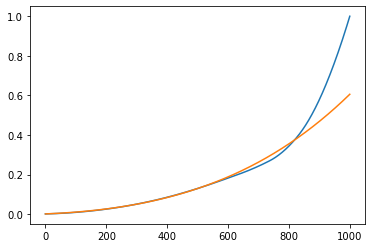

In [21]:
plt.plot(x_t_m_p1[:,1])
plt.plot(predicted_states[:,1])

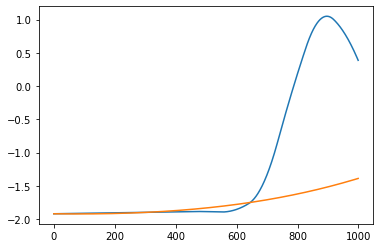

In [22]:
plt.plot(x_t_m_p1[:,2])
plt.plot(predicted_states[:,2])

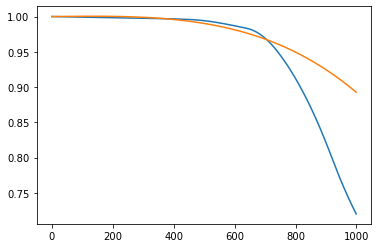

In [24]:
plt.plot(x_t_m_p1[:,3])
plt.plot(predicted_states[:,3])

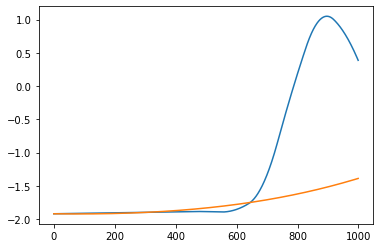

In [18]:
plt.plot(x_t_m_p1[:,2])
plt.plot(predicted_states[:,2])

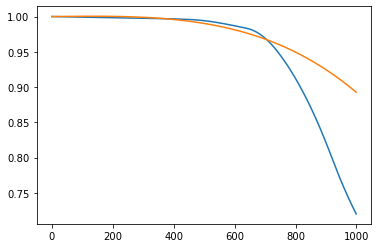

In [19]:
plt.plot(x_t_m_p1[:,3])
plt.plot(predicted_states[:,3])